<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-Statement-of-Intent-" data-toc-modified-id="Introduction-and-Statement-of-Intent--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and Statement of Intent <a name="introduction"></a></a></span></li><li><span><a href="#Pulse-Response-Zero-Forcing" data-toc-modified-id="Pulse-Response-Zero-Forcing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pulse Response Zero Forcing</a></span></li></ul></div>

# DFE Modeling for Equalization Optimization <a name="top"/>

Original author: David Banas <capn.freako@gmail.com>  
Original date:   December 11, 2016

Copyright (c) 2016 David Banas; all rights reserved World wide.

This [iPython notebook](http://ipython.org/ipython-doc/3/notebook/notebook.html#introduction) explores the topic of modeling [DFE](https://www.quora.com/How-does-a-Decision-Feedback-Equalizer-DFE-work) behavior when [optimizing equalization](http://www.ti.com/tool/TIDA-00353).

It draws upon the [pybert](https://github.com/capn-freako/PyBERT/wiki) Python package. You will need this package installed, in order to run/modify this notebook.


## Introduction and Statement of Intent <a name="introduction"/>

When optimizing high speed serial communication link equalization, it is important to include the effects of the decision feedback equalizer (DFE), when calculating the cost function of the equalization algorithm, as not doing so might result in a gross underutilization of this very powerful component and a resultant non-optimum eye. However, it is often not feasible to allow the DFE to fully adapt and process the sample data stream, at every iteration of the optimization algorithm, due to modeling performance limitations. That is, the DFE model often simply takes too long to run, to be included in an algorithmic loop, which runs an appreciable number of times.

As a result, several "tricks" for modeling the DFE behavior with less computational overhead have been tried and published in the literature. Here, we assess one such trick: *pulse response zero forcing*. We first explain the technical details of this approach to DFE modeling and then test its practical usefulness, by attempting to use it in a real link equalization optimization exercise, evaluating the results.

## Pulse Response Zero Forcing

The idea behind pulse response zero forcing follows from the observation that the DFE tries to bring the system pulse response to zero, at every clock instant after the cursor, up to a maximum number, N, which is equal to the number of taps in the DFE filter. The code, below, along with its associated figures, illustrate this.

Simulation/Model Notes:

- The channel is modeled, using Dr. Howard Johnson's *Metalic Transmission Model* with the following assumptions:
  - Channel length = 1m
  - Channel material is 24 guage copper unshielded twisted pair.
  - Both Tx outputs and both Rx inputs are assumed to have 0.5 pF parasitic capacitance.
- The simulation control parameters are as follows:
  - Bit rate = 10 Gbps
  - Pattern length = 127 bits
  - Samples per bit = 32
  - Modulation = NRZ
  - CTLE peak location = 5 GHz
  - CTLE type = 'passive' (i.e. - |H(f)| <= 1)
  - Unequalized Rx signal path bandwidth = 12 GHz
  

In [1]:
%matplotlib inline
from matplotlib import pyplot   as plt
from numpy      import array
from time       import sleep
from pybert     import pybert

myPyBERT = pybert.PyBERT(run_simulation=False)
myPyBERT.ctle_mode_tune = 'Passive'
myPyBERT._btn_opt_rx_fired()
while(myPyBERT.rx_opt_thread.isAlive()):
    sleep(0.1)
print "Settings:"
print "\tUse DFE:", myPyBERT.use_dfe_tune
print "\t# of DFE taps:", pybert.gNtaps
print "Results:"
print "\tCTLE Magnitude:", myPyBERT.peak_mag_tune, "dB"
print "\tRelative Optimization:", myPyBERT.rel_opt
t                = myPyBERT.t
t_ns             = t * 1.e9
pulse_resp_ideal = myPyBERT.plotdata['ctle_out_h_tune']
clocks_tune      = myPyBERT.plotdata['clocks_tune']
plt.plot(t_ns[:len(pulse_resp_ideal)], pulse_resp_ideal)
plt.plot(t_ns[:len(clocks_tune)],      clocks_tune)
plt.title('System Pulse Response After Optimization - Perfect DFE assumed.')
plt.ylabel('Pulse Response (V)')
plt.xlabel('Time (ns)')
plt.axis(xmin=0.5, xmax=1.5)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Settings:")? (<ipython-input-1-c3de36f3fdca>, line 12)

The plot, above, shows the *assumed*, or *ideal*, system pulse response after Rx optimization, $\hat{p}(t)$, along with the estimated sample clock instants. The reported final optimization metric (i.e. - "Relative Optimization") is simply taken as the negative of the cost function used during optimization. And that cost function is defined as:

$$
cost = \sum_{n \neq 0}{abs[\hat{p}(nT)]} - \hat{p}(0)
$$

where *T* is the clock period and *n* is the clock instant index, with index "0" referring to the main lobe.

Essentially, we are defining *cost* as *ISI* minus the main lobe height.

Note that, for the first 5 post-cursor clocking instants, the system pulse response has been assumed zero, due to the action of an ideal DFE. This is the *pulse response zero forcing* assumption.

Let's see how our eye looks, using the "optimum" CTLE peak magnitude found, above...

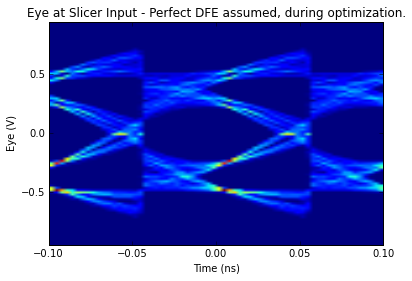

In [2]:
from numpy              import linspace
from pybert.pybert_util import calc_eye

self = myPyBERT  # In order to avoid changing "self" to "myPyBERT" in many places, below.

self._btn_save_eq_fired()
self.gain            = 0.5  # DFE correction gain.
self.decision_scaler = 0.4  # Approx. pulse response magnitude, above.
pybert.my_run_simulation(self, initial_run=True, update_plots=False)

# The code, below, is taken from 'pybert_cntrl.py'.
# I'm recreating this functionality, here, instead of just letting 'myPyBERT' do the job, for two reasons:
#  1. The eye generation is one of the slower parts of the code, and many eyes are generated;
#     we're only interested in one of those, here.
#  2. There is the potential for graphics back-end conflict, between myPyBERT and this notebook,
#     to occur, if I call upon the graphics-related functionality of myPyBERT, here.
ui            = self.ui
samps_per_ui  = self.nspui
eye_uis       = self.eye_uis
num_ui        = self.nui
clock_times   = self.clock_times
ignore_until  = (num_ui - eye_uis) * ui

width    = 2 * samps_per_ui
xs       = linspace(-ui * 1.e12, ui * 1.e12, width)
height   = 100
i = 0
while(clock_times[i] <= ignore_until):
    i += 1
    assert i < len(clock_times), "ERROR: Insufficient coverage in 'clock_times' vector."
y_max    = 1.1 * max(abs(array(self.dfe_out)))
eye_dfe  = calc_eye(ui, samps_per_ui, height, self.dfe_out, y_max, clock_times[i:])
plt.imshow(eye_dfe, extent=[-ui * 1.e9, ui * 1.e9, -y_max, y_max], aspect='auto')
plt.xlabel('Time (ns)')
plt.ylabel('Eye (V)')
plt.title('Eye at Slicer Input - Perfect DFE assumed, during optimization.')


Okay, looks pretty good. Note that the eye, above, was generated after letting the *actual* DFE adapt normally. The "Perfect DFE assumed." in the plot title refers only to the optimization of the CTLE peaking magnitude.

Let's make sure the DFE fully adapted...

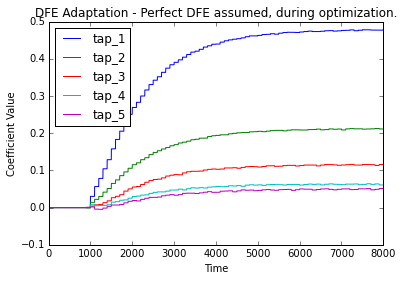

In [3]:
i = 1
for item in array(myPyBERT.adaptation).transpose():
    plt.plot(item, label='tap_{}'.format(i))
    i += 1
plt.legend(loc='upper left')
plt.title('DFE Adaptation - Perfect DFE assumed, during optimization.')
plt.ylabel('Coefficient Value')
plt.xlabel('Time')


It certainly appears that the DFE has adapted to a stable state.

Let's check the pulse response of this stable, adapted system against our ideal assumption, above...

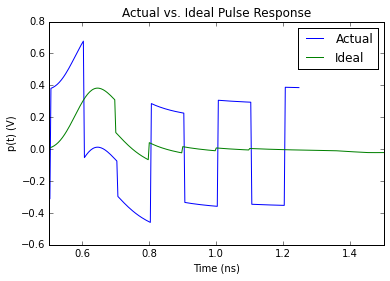

In [4]:
# Calculate and plot the pulse response of fully adapted PyBERT instance.
# We assume everything up to the DFE is LTI.
# Therefore, we take, as the input to the DFE, the system pulse response up to that point.
from numpy      import concatenate, convolve, repeat
from pybert.dfe import DFE

self = myPyBERT

nspui           = self.nspui
delta_t         = self.delta_t * 1.e-12
alpha           = self.alpha
ui              = self.ui
n_taps          = self.n_taps
gain            = 0.                       # Kills adaptation.
n_ave           = self.n_ave
decision_scaler = self.decision_scaler
n_lock_ave      = self.n_lock_ave
rel_lock_tol    = self.rel_lock_tol
lock_sustain    = self.lock_sustain
bandwidth       = self.sum_bw * 1.e9
rel_thresh      = self.thresh
mod_type        = self.mod_type[0]

# We instantiate a pre-adapted, static DFE, as follows:
#  - Pass '0' for the second parameter (adaptation gain); this kills adaptation.
#  - Load the tap weights, after instantiation, with those of the adapted DFE, above.
dfe = DFE(  n_taps, gain, delta_t, alpha, ui, nspui, decision_scaler, mod_type,
            n_ave=n_ave, n_lock_ave=n_lock_ave, rel_lock_tol=rel_lock_tol,
            lock_sustain=lock_sustain, bandwidth=bandwidth, ideal=self.sum_ideal)
dfe.tap_weights = self.adaptation[-1]  # In Python, "-1" given as an array index returns the last element.

dfe_in = self.ctle_out_p.copy()         # System pulse response, up to DFE input.
(dfe_out, tap_weights, ui_ests, clocks, lockeds, clock_times, bits_out) = dfe.run(t[:len(dfe_in)], dfe_in)
plt.plot(t_ns[:len(dfe_out)], dfe_out, label='Actual')
plt.plot(t_ns[:len(pulse_resp_ideal[nspui:])], pulse_resp_ideal[nspui:], label='Ideal')
plt.legend(loc='upper right')
plt.axis(xmin=0.5, xmax=1.5)
plt.title('Actual vs. Ideal Pulse Response')
plt.xlabel('Time (ns)')
plt.ylabel('p(t) (V)')


The plot, above, illustrates an interesting property of DFEs: they oscillate, when their inputs are too close to zero! And, unfortunately, this prevents us from testing our *perfect DFE* assumption, using the pulse response. However, there's always the *step* response...

We can derive the step response required, in order to produce the *perfect DFE* pulse response, above, as follows:

\begin{align}
\hat{p}(t) & = \hat{s}(t) - \hat{s}(t - T) \\
\hat{p}(nT) & = \hat{s}(nT) - \hat{s}((n - 1)T) = 0 , \; n > 0 \\
\end{align}

or

$$\hat{s}(nT) = \hat{s}((n - 1)T) , \; n > 0$$

where:

- $\hat{p}$ is the *perfect DFE* system pulse response shown, above,
- $\hat{s}$ is the equivalent step response, and
- $T$ is the unit interval.

We can easily construct such a step response, starting with our actual post-CTLE system step response, as follows:


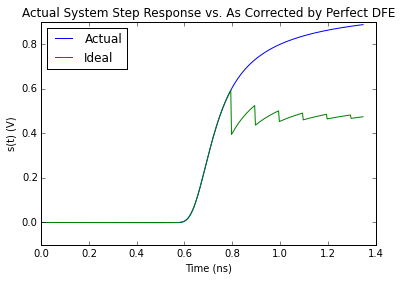

In [5]:
from numpy import where

s_hat = myPyBERT.ctle_out_s.copy()
idx = where(myPyBERT.ctle_out_p == max(myPyBERT.ctle_out_p))[0][0]
idx += 2 * nspui  # There's a 1 UI delay in the pulse response calculated by PyBERT.
while(idx < len(s_hat)):
    s_hat[idx - nspui/2:] -= s_hat[idx] - s_hat[idx - nspui]
    idx += nspui
plt.plot(t_ns[:len(myPyBERT.ctle_out_s)], myPyBERT.ctle_out_s, label='Actual')
plt.plot(t_ns[:len(s_hat)], s_hat, label='Ideal')
plt.title('Actual System Step Response vs. As Corrected by Perfect DFE')
plt.xlabel('Time (ns)')
plt.ylabel('s(t) (V)')
plt.legend(loc='upper left')


And, now, we can compare this ideal step response with our actual step response, by sending the step response of our system, up to the DFE input, through the fully adapted DFE...

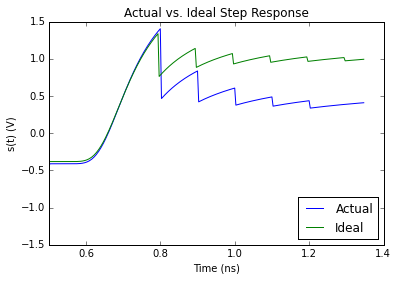

In [6]:
# Calculate and plot the step response of fully adapted PyBERT instance.
# We assume everything up to the DFE is LTI.
# Therefore, we take, as the input to the DFE, the system step response up to that point.

# We instantiate a pre-adapted, static DFE, as follows:
#  - Pass '0' for the second parameter (adaptation gain); this kills adaptation.
#  - Load the tap weights, after instantiation, with those of the adapted DFE, above.
dfe = DFE(  n_taps, gain, delta_t, alpha, ui, nspui, decision_scaler, mod_type,
            n_ave=n_ave, n_lock_ave=n_lock_ave, rel_lock_tol=rel_lock_tol,
            lock_sustain=lock_sustain, bandwidth=bandwidth, ideal=self.sum_ideal)
dfe.tap_weights = self.adaptation[-1]

dfe_in = self.ctle_out_s.copy()         # System step response, up to DFE input.
dfe_in -= 0.5 * max(dfe_in)             # Make it d.c. balanced.
dfe_in *= 3.                            # Provide just enough scaling to avoid DFE oscillation.

ref = s_hat.copy()                      # Reference waveform is arbitrarily scaled and offset,
ref *= 2.9                              # in order to match "front porch" and first positive
ref -= 0.38                             # sample values.

(dfe_out, tap_weights, ui_ests, clocks, lockeds, clock_times, bits_out) = dfe.run(t[:len(dfe_in)], dfe_in)
plt.plot(t_ns[:len(dfe_out)], dfe_out, label='Actual')
plt.plot(t_ns[:len(ref)], ref, label='Ideal')
plt.axis(xmin=0.5)
plt.title('Actual vs. Ideal Step Response')
plt.xlabel('Time (ns)')
plt.ylabel('s(t) (V)')
plt.legend(loc='lower right')


Hmm, not a very good match. Let's calculate the pulse response implied by this new step response, and compare back to our ideal pulse response...

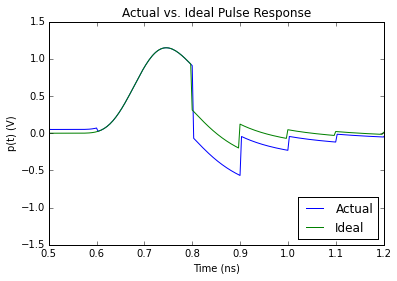

In [7]:
from numpy import pad

p_test = dfe_out - pad(dfe_out[:-nspui], (nspui,0), 'constant', constant_values=(0,0))
plt.plot(t_ns[:len(p_test)], p_test, label='Actual')
plt.plot(t_ns[:len(pulse_resp_ideal)], pulse_resp_ideal * 3., label='Ideal')
plt.axis(xmin=0.5, xmax=1.2)
plt.legend(loc='lower right')
plt.title('Actual vs. Ideal Pulse Response')
plt.xlabel('Time (ns)')
plt.ylabel('p(t) (V)')


So, our *zero forcing* approach to including the DFE behavior in link optimization is not perfect. But, how does it compare to the results we get, when we optimize Rx equalization assuming no DFE?

Results:
	CTLE Magnitude: 14.0751869184 dB
	Relative Optimization: 0.126056937284


(0.5, 1.2, -0.050000000000000003, 0.25000000000000006)

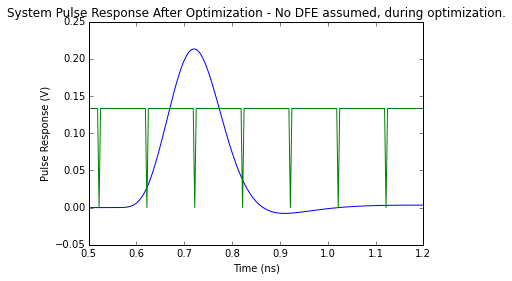

In [8]:
myPyBERT.use_dfe_tune = False
myPyBERT._btn_opt_rx_fired()
while(myPyBERT.rx_opt_thread.isAlive()):
    sleep(0.1)
print "Results:"
print "\tCTLE Magnitude:", myPyBERT.peak_mag_tune, "dB"
print "\tRelative Optimization:", myPyBERT.rel_opt
pulse_resp_nodfe = myPyBERT.plotdata['ctle_out_h_tune']
clocks_tune      = myPyBERT.plotdata['clocks_tune']
plt.plot(t_ns[:len(pulse_resp_nodfe)], pulse_resp_nodfe)
plt.plot(t_ns[:len(clocks_tune)],      clocks_tune)
plt.title('System Pulse Response After Optimization - No DFE assumed, during optimization.')
plt.ylabel('Pulse Response (V)')
plt.xlabel('Time (ns)')
plt.axis(xmin=0.5, xmax=1.2)


The optimum CTLE peaking magnitude found is much larger than in the previous case (14 dB vs. 2.8 dB), while the reported *Relative Optimization* is less than half (0.13 vs. 0.28)!

Let's see what the new eye looks like...

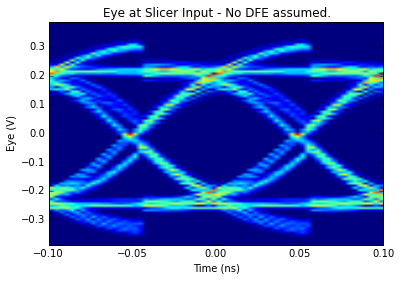

In [9]:
self._btn_save_eq_fired()
self.use_dfe = True  # It gets turned off, by the above step.
pybert.my_run_simulation(self, initial_run=True, update_plots=False)

ui            = self.ui
samps_per_ui  = self.nspui
eye_uis       = self.eye_uis
num_ui        = self.nui
clock_times   = self.clock_times
ignore_until  = (num_ui - eye_uis) * ui

width    = 2 * samps_per_ui
xs       = linspace(-ui * 1.e12, ui * 1.e12, width)
height   = 100
i = 0
while(clock_times[i] <= ignore_until):
    i += 1
    assert i < len(clock_times), "ERROR: Insufficient coverage in 'clock_times' vector."
y_max    = 1.1 * max(abs(array(self.dfe_out)))
eye_nodfe  = calc_eye(ui, samps_per_ui, height, self.dfe_out, y_max, clock_times[i:])
plt.set_cmap('jet')
plt.imshow(eye_nodfe, extent=[-ui * 1.e9, ui * 1.e9, -y_max, y_max], aspect='auto')
plt.xlabel('Time (ns)')
plt.ylabel('Eye (V)')
plt.title('Eye at Slicer Input - No DFE assumed.')


The inner eye height is significantly diminished, in this case (approx. 300mV vs. 500 mV, previously).

But, what about the DFE, this time?

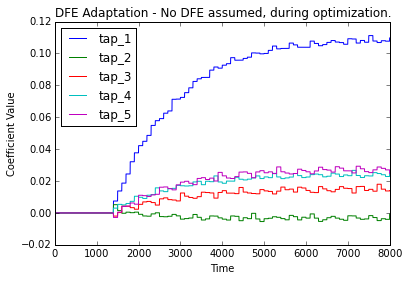

In [10]:
i = 1
for item in array(myPyBERT.adaptation).transpose():
    plt.plot(item, label='tap_{}'.format(i))
    i += 1
plt.legend(loc='upper left')
plt.title('DFE Adaptation - No DFE assumed, during optimization.')
plt.ylabel('Coefficient Value')
plt.xlabel('Time')


As we might have suspected, the DFE is hardly being used, in this case. This is not really a surprise, as we optimized the Rx equalization under the assumption that no DFE was present. And, as is evidenced by the diminished inner eye height, we have paid a price for ignoring the DFE contribution to overall link equalization, during optimization. It would appear that, despite its imperfections, the *zero forcing* approach to including DFE behavior in the Rx equalization optimization process definitely yields superior results than simply ignoring the DFE, during optimizatioon.